## Automatic Learning of Summary Statistics for Approximate Bayesian Computation Using Deep Learning



Samuel Wiqvist, Ph.D. Student, Lund University.

Work with: Pierre-Alexandre Mattei (ITU), Umberto Picchini (GU/Chalmers), and Jes Frellsen (ITU). 

In [1]:
# load packages and set up
using PyPlot
using Distributions
using Printf
using Random 
using KernelDensity

# data model
Random.seed!(12)
α = 2; β = 2
m = 4; n = 5; p = 0.7
y_obs = rand(Binomial(m,p),n) # generate data

# analytical posterior
posterior = Beta(α + sum(y_obs), β + m*n - sum(y_obs));

# plot function
function plot_abc_inference_results(abc_posterior_samples)
    
    kde_approx_posterior = kde(abc_posterior_samples)

    # plot results
    PyPlot.figure(figsize=(7,4))
    PyPlot.plot(kde_approx_posterior.x,kde_approx_posterior.density, "b")
    PyPlot.plot(0:0.01:1,pdf.(posterior, 0:0.01:1), "r")
    PyPlot.plot(0:0.01:1, pdf.(prior, 0:0.01:1), "g")
    PyPlot.plot((p, p), (0, maximum(pdf.(posterior, 0:0.01:1))), "k")
    PyPlot.xlabel("p")
    PyPlot.ylabel("Density")
    PyPlot.legend(["ABC posterior"; "Analytical posterior"; "Prior"; "True value"])

end 

plot_abc_inference_results (generic function with 1 method)

#### What we will talk about today

* Introduction to ABC;
* How we can leverage Deep Learnings methods to learn the summary statistics for ABC; 
    * Present the main results from the paper:  *Partially exchangeable networks and architectures for learning summary statistics in approximate* (accepted for ICML 2019);
* We will have a practical focus and run ABC for a simple model (the Beta-Binomial model).   


#### Approxiamte Bayesian Computation: Simulation based inference 

* ABC in a nut-shell: Simulations-based inference method where we generate parameter proposals $\theta^\star$ and accept $\theta^\star$ if the generated data $y^{\star}\sim p(y|\theta^\star)$ is *similar* to our observed data $y^{\text{obs}}$;
* ABC only requires that we can simulate data from our model $p(y|\theta)$, thus ABC is very generic, and can be applied for models where the likelihood is intractable.   
* *Curse-of-dimensionality*: Instead of comparing the data sets we compare a set of summary statistics $s =S(y)$. The main focus of our work is how we  \textit{automatically} can learn the summary statistics.

#### Approxiamte Bayesian Computation: Rejection sampling method 


* Generate $\tilde{N}$ independent proposals $\theta^i\sim p(\theta)$,  and corresponding data  $y^i\sim p(y|\theta^i)$ from the simulator $p(y|\theta^\star)$;
* Compute the summary statistics $s^i = S(y^i)$ for each $i=1,\ldots,\tilde{N}$;
* Compute the distances $\Delta(s^{i}, s^{\text{obs}})$ for each $i=1,\ldots,\tilde{N}$. 
* Retain proposals $\theta^i$ corresponding to those $\Delta(s^{i}, s^{\text{obs}})$ that are smaller than some threshold $\epsilon > 0$. %$the $x$-th percentile of all distances. 
 
            



#### Approxiamte Bayesian Computation: Approxiamte posterior 


* Thus we sample form the ABC posterior:
$$p^{\epsilon}_{\text{ABC}}(\theta | s^{\text{obs}}) \propto \int I(\Delta(s^{\star},s^{\text{obs}}) < \epsilon) p(s^{\star}|\theta) p(\theta) ds^{\star}.$$
Where $s^{\text{obs}} = S(y^{\text{obs}})$, $I$ indicator kernel, $\Delta$ distance function, and $\epsilon$ the threshold.

NEED TO UPDATE/REDO THIS SLIDE


#### ABC rejection sampling for the Beta-Binomial model

In [2]:
# Define the model and the prior distribution.

Random.seed!(12) # fix random numbers 

# model parameters
m = 4; n = 5; p_true = 0.7

 # defined the data generating function
data_generator(p) = rand(Binomial(m,p),n) 

# generate data
y_obs = data_generator(p_true)

# prior 
α = 2; β = 2
prior = Beta(α,β);

#### ABC rejection sampling for the Beta-Binomial model 

In [3]:
# ABC rejection sampling algorithm 
function abc_rs(;N_proposals::Int, ϵ::Real)
    
    abc_posterior_samples = zeros(N_proposals)
    nbr_accapted_proposals = 0 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the data model
        Δ = sum(abs.(sort(y_star)-sort(y_obs))) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accapted_proposals += 1 
            abc_posterior_samples[nbr_accapted_proposals] = p_star 
        end 
    end 
    
    return abc_posterior_samples[1:nbr_accapted_proposals]
end; 

#### ABC rejection sampling for the Beta-Binomial model 

In [4]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 0);
@printf "Accaptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Accaptance rate: 0.35 %

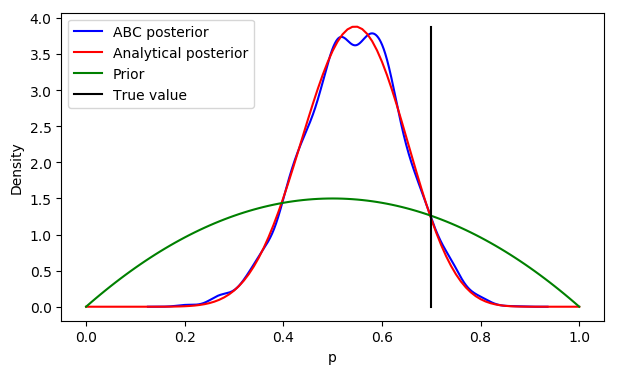

In [5]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### ABC rejection sampling for the Beta-Binomial model (with summary statistics)

In [6]:
# defined the summary statistics 
S(y) = [mean(y); std(y)];

In [7]:
# ABC rejection sampling algorithm 
function abc_rs_summary_stats(;N_proposals::Int, ϵ::Real, S::Function)
    
    abc_posterior_samples = zeros(N_proposals)
    nbr_accapted_proposals = 0 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the data model
        Δ = sum(abs.(S(y_star)-S(y_obs))) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accapted_proposals += 1 
            abc_posterior_samples[nbr_accapted_proposals] = p_star 
        end 
    end 
    
    return abc_posterior_samples[1:nbr_accapted_proposals]
end; 

#### ABC rejection sampling for the Beta-Binomial model (with summary statistics)

In [8]:
# Run ABC rejection sampling
abc_posterior_samples = abc_rs_summary_stats(N_proposals = 10^6, ϵ  = 0.2, S=S);
@printf "Accaptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Accaptance rate: 1.77 %

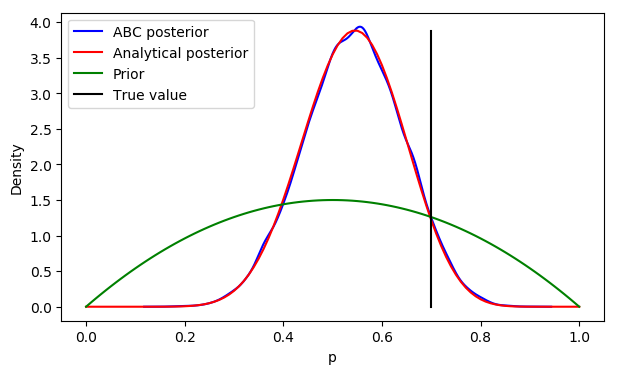

In [9]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);

#### How to select/learn summary statistics

* The summary statistics *should* be low-dimensional and informative for the parameters (in the ideal case sufficient).
* The problem of selecting informative summary statistics is the main challenge when applying ABC in practice;
* Usually, summary statistics are ad-hoc and "handpicked" out of subject-domain expertise. For example for dynamic models, summaries can be autocorrelations, cross-covariances, stationary mean. For iid data could be quantiles, mean and standard deviation etc.;
* Several methods to learn/select summary statistics have been developed (see (Prangle, 2015) for a review on these methods);


#### Learning summary statistics using linear regression

* An important paper is (Fearnhead, 2012) where they use linear regression to learn summary statistics, they also show that the posterior mean is the *best* (in terms of loss for the posterior mean) summary statistic; 



#### Semi-automatic ABC (the method from (Fearnhead, 2012))


* We can sample a set of parameter-data pairs $(\theta^{i}, y^i)_{1 \leq i \leq N}$, by sampling $\theta^{i}$ from the prior, and then simulate corresponding data set $y^{i}$ from the simulator $p(y|\theta)$;
* Learn the posterior mean from the $N$ simulations,  using a linear regression model: $$\theta_j^i = E(\theta_j | y^i) + \xi_j^i = b_{0_j} + b_j h(y^i) + \xi_j^i.$$
* After fitting the linear regression model $\tilde{b}_{0_j} + \tilde{b}_j h(y^{\star})$ is the j:th summary statistics for the proposed data set $y^{\star}$. 

    

#### The end

Homepage: http://www.maths.lu.se/staff/samuel-wiqvist/

Github: SamuelWiqvist

Twitter: samuel_wiqvist

#### Outline 

* Intro to ABC with simple Beta-Bionomial model (we will only have one simple example since it is really annoying to create the slides for the code examples)
* Something on summary statistics 
* Why we want the PEN network 
* How the PEN network works, why it is particular suitable for timeseries 
* Something on our results (MA2 model with noise)
* It could be nice to use PEN for the simple Beta-Bionomial model so that we show the full workflow (perhaps it would be better to use a MLP example and then only show the results from the paper without running the calculations)

#### References 

(Prangle, 2015) Bla bla bla

(Fearnhead, 2012 Bla bla bla 